In [1]:
!pip install gdown

In [2]:
import gdown

In [5]:
# a file
url = "https://drive.google.com/uc?id=1--Bg68-R8UIzqwlwSBodWd4N99UwzzJv"
output = "Dataset.rar"
gdown.download(url, output)

Downloading...
From (original): https://drive.google.com/uc?id=1--Bg68-R8UIzqwlwSBodWd4N99UwzzJv
From (redirected): https://drive.google.com/uc?id=1--Bg68-R8UIzqwlwSBodWd4N99UwzzJv&confirm=t&uuid=0b3e621a-bcf5-461f-9894-802ffcee3891
To: /kaggle/working/Dataset.rar
100%|██████████| 224M/224M [00:02<00:00, 98.5MB/s] 


'Dataset.rar'

In [6]:
!ls /kaggle/working/

 Dataset.rar  'view?usp=sharing'


In [7]:
!sudo apt install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  unrar
0 upgraded, 1 newly installed, 0 to remove and 72 not upgraded.
Need to get 145 kB of archives.
After this operation, 339 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 unrar amd64 1:6.1.5-1 [145 kB]
Fetched 145 kB in 0s (1941 kB/s)

78Selecting previously unselected package unrar.
(Reading database ... 122997 files and directories currently installed.)
Preparing to unpack .../unrar_1%3a6.1.5-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 20%] [###########...............................................] 8Unpacking unrar (1:6.1.5-1) ...
7Progress: [ 40%] [#######################...................................] 8Setting up unrar (1:6.1.5-1) ...
7Progress: [ 60%] [##################################.............

In [10]:
!unrar x /kaggle/working/Dataset.rar /kaggle/working/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /kaggle/working/Dataset.rar

Creating    /kaggle/working/content                                   OK
Creating    /kaggle/working/content/drive                             OK
Creating    /kaggle/working/content/drive/MyDrive                     OK
Creating    /kaggle/working/content/drive/MyDrive/Dataset             OK
Extracting  /kaggle/working/content/drive/MyDrive/Dataset/metadata.csv     0  OK 
Extracting  /kaggle/working/content/drive/MyDrive/Dataset/drivekoko.zip              1 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 49  OK 
Creating    /kaggle/working/content/drive/MyDrive/Dataset/Image       OK
Extracting  /kaggle/working/content/drive/MyDrive/Dataset/Image/1.jpg    49  OK 
Extracting  /kaggle/working/content/drive/MyDrive/Dataset/Image/10.jpg    50  OK 
Extracting  /kaggle/working/content/drive/MyDrive/Dataset/Image/1000.jpg    50  OK 
Extracting  /kaggle/working/content/drive/MyDrive/

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Learning Objectives:

1. Understand and implement Variational Autoencoders for image colorization.
2. Apply the U-Net architecture for image segmentation.
3. Preprocess image datasets, including augmentation techniques.
4. Analyze the performance of machine learning models using relevant metrics.
5. Explore the relationship between latent space and output quality in generative models.


# Image Colorization using VAE
implement and fine-tune an autoencoder network, utilizing components like perceptual loss and feature extraction from pre-trained models, to improve colorization output. By doing so, they will gain a deeper understanding of generative models and their practical applications in computer vision tasks. This exercise offers a hands-on opportunity to blend theoretical knowledge with practical coding skills, characterizing the creative potential of AI in image processing.

Dataset: https://drive.google.com/drive/folders/1KeJbfUykGnPlz0q08_b1IjtW8OxkPdQ9?usp=sharing

## Importing Libraries

In [ ]:
!pip install pytorch_lightning
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 55.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Metric
import torchvision
import torchvision.models as models
from PIL import Image
from sklearn.manifold import TSNE
import torch.optim as optim
print(plt.style.available)
plt.style.use('seaborn-v0_8')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

np.__version__, device

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


('1.26.4', 'cuda')

## Loading the Data

In [ ]:
# Function to load data from a given path
def load_data(PATH):
    file_paths = []
    categories = []

    for folder in tqdm(os.listdir(PATH)):
        folder_path = os.path.join(PATH, folder)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                file_paths.append(image_path)
                categories.append(folder)

    data_frame = pd.DataFrame({
        'filename': file_paths,
        'label': categories
    })

    data_frame['outcome'] = pd.factorize(data_frame['label'])[0]

    data_frame = data_frame.sample(frac=1, random_state=42).reset_index(drop=True)

    return data_frame
train_dir = "/content/drive/MyDrive/data/train"
valid_dir = "/content/drive/MyDrive/data/valid"
test_dir = "/content/drive/MyDrive/data/test"
train_data = load_data(train_dir)
valid_data = load_data(valid_dir)
test_data = load_data(test_dir)
print(train_data.shape, valid_data.shape, test_data.shape)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

(3208, 3) (100, 3) (100, 3)


In [ ]:
# TODO: Combine the training and test data into a single DataFrame along the vertical axis
merged_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

print(merged_data.shape)

(3308, 3)


In [ ]:
# TODO: Explore the new DataFrame
merged_data

filename  \
0     /content/drive/MyDrive/data/train/AFRICAN CROW...   
1     /content/drive/MyDrive/data/train/AMERICAN AVO...   
2     /content/drive/MyDrive/data/train/ALBERTS TOWH...   
3     /content/drive/MyDrive/data/train/ALBERTS TOWH...   
4     /content/drive/MyDrive/data/train/ALBERTS TOWH...   
...                                                 ...   
3303  /content/drive/MyDrive/data/test/AMERICAN COOT...   
3304  /content/drive/MyDrive/data/test/ABYSSINIAN GR...   
3305  /content/drive/MyDrive/data/test/ALBERTS TOWHE...   
3306   /content/drive/MyDrive/data/test/ALBATROSS/2.jpg   
3307  /content/drive/MyDrive/data/test/AFRICAN EMERA...   

                           label  outcome  
0          AFRICAN CROWNED CRANE        3  
1                AMERICAN AVOCET       19  
2                 ALBERTS TOWHEE       18  
3                 ALBERTS TOWHEE       18  
4                 ALBERTS TOWHEE       18  
...                          ...      ...  
3303               AMERICAN COOT       12  
3304  ABYSSINIAN GROUND HORNBILL       14  
3305              ALBERTS TOWHEE        2  
3306                   ALBATROSS       18  
3307      AFRICAN EMERALD CUCKOO       10  

[3308 rows x 3 columns]

## Plot some of the images

In [ ]:
# TODO: Plot some of images
def display_images_by_label(dataframe, num_images_per_label=3):
    labels = dataframe['label'].unique()
    plt.figure(figsize=(15, len(labels) * 5))

    for i, label in enumerate(labels):
        label_data = dataframe[dataframe['label'] == label].sample(num_images_per_label, random_state=42)

        for j, (idx, row) in enumerate(label_data.iterrows()):
            img = Image.open(row['filename'])

            plt.subplot(len(labels), num_images_per_label, i * num_images_per_label + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(label)

    plt.tight_layout()
    plt.show()

display_images_by_label(merged_data, num_images_per_label=3)

## Dataset Distribution
plot the distribution of the dataset, both training and validation set

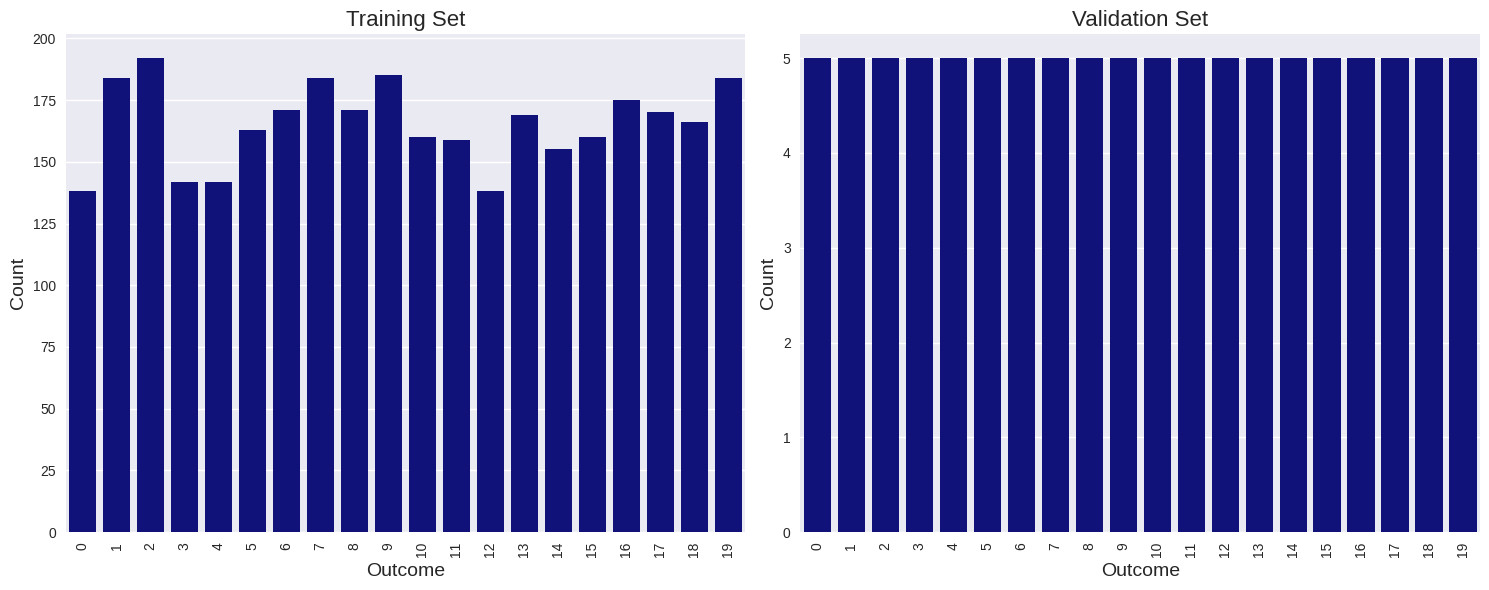

In [ ]:
# TODO: Plot the distribution of classes
def plot_distribution_comparison(df1, df2, label1="Dataset 1", label2="Dataset 2"):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    sns.countplot(x=df1['outcome'], order=sorted(df1['outcome'].unique()), color='darkblue', ax=axes[0])
    axes[0].set_title(f"{label1}", fontsize=16)
    axes[0].set_xlabel("Outcome", fontsize=14)
    axes[0].set_ylabel("Count", fontsize=14)
    axes[0].tick_params(axis='x', rotation=90)

    sns.countplot(x=df2['outcome'], order=sorted(df2['outcome'].unique()), color='darkblue', ax=axes[1])
    axes[1].set_title(f"{label2}", fontsize=16)
    axes[1].set_xlabel("Outcome", fontsize=14)
    axes[1].set_ylabel("Count", fontsize=14)
    axes[1].tick_params(axis='x', rotation=90)

    plt.tight_layout()
    plt.show()

plot_distribution_comparison(merged_data, valid_data, label1="Training Set", label2="Validation Set")

## Dataset Preparation
Now we are going to build the dataset by using `Dataset` and `DataLoader` classes within PyTorch. I recommend you to randomly crop the images to (160, 160) and then normalize them.

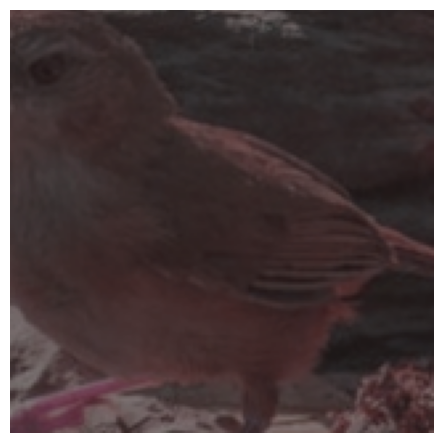

In [ ]:
# Define a custom Dataset class
class BirdDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filename']
        label = self.df.iloc[idx]['outcome']
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label

# Define transformations for the images
transform = transforms.Compose([
    transforms.RandomResizedCrop(160),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and data loaders
train_dataset = BirdDataset(df=merged_data, transform=transform)
valid_dataset = BirdDataset(df=valid_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

def display_sample_image(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    images = images * torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)

    img = transforms.ToPILImage()(images[0])

    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display a random sample image
display_sample_image(train_loader)


**Why is data augmentation pivotal in training models for image tasks, and what techniques are beneficial for this particular assignment?**

**Data augmentation plays a crucial role in training image-based models. It enhances the diversity of the dataset by creating variations of the original images, like rotating, flipping, adjusting colors, or adding noise. This helps the model generalize better to new data and reduces overfitting by encouraging it to learn meaningful features instead of memorizing details. It’s especially useful for small or imbalanced datasets by effectively generating additional training examples, leading to improved model performance and adaptability. Common techniques include flipping, cropping, resizing, rotating, color adjustments, and noise addition, customized for the task at hand.**

## Model Architecture
The model has an encoder block for encoding the grayscale image into a lower representation followed by a decoder block to generate the colorized image.

In [ ]:
class PerceptualLoss(nn.Module):
    def __init__(self, use_gpu=True):
        super(PerceptualLoss, self).__init__()
        self.vgg = models.vgg16(pretrained=True).features
        self.layers = {'3': 'relu1_2', '8': 'relu2_2', '15': 'relu3_3', '22': 'relu4_3'}
        for param in self.vgg.parameters():
            param.requires_grad = False
        if use_gpu and torch.cuda.is_available():
            self.vgg = self.vgg.to('cuda')

    def forward(self, x, y):
        loss = 0.0
        x_input = x
        y_input = y
        for name, module in self.vgg._modules.items():
            x_input = module(x_input)
            y_input = module(y_input)
            if name in self.layers:
                loss += nn.functional.mse_loss(x_input, y_input)
        return loss


class Encoder(nn.Module):
    def __init__(self, do_bn=False):
        super(Encoder, self).__init__()
        self.do_bn = do_bn
        self.block1 = self.inner_block(3, 64)
        self.block2 = self.inner_block(64, 128)
        self.block3 = self.inner_block(128, 256)
        self.block4 = self.inner_block(256, 512)
        self.block5 = self.inner_block(512, 1024)

    def inner_block(self, in_c, out_c):
        layers = [
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c) if self.do_bn else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        return x


class Decoder(nn.Module):
    def __init__(self, do_bn):
        super(Decoder, self).__init__()
        self.do_bn = do_bn
        self.block1 = self.inner_block(1024, 512)
        self.block2 = self.inner_block(512, 256)
        self.block3 = self.inner_block(256, 128)
        self.block4 = self.inner_block(128, 64)
        self.block5 = self.conv_block(64, 3)

    def inner_block(self, in_c, out_c):
        layers = [
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c) if self.do_bn else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        ]
        return nn.Sequential(*layers)

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, h):
        h = self.block1(h)
        h = self.block2(h)
        h = self.block3(h)
        h = self.block4(h)
        h = self.block5(h)
        return h


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = Encoder(do_bn=True)
        self.decoder = Decoder(do_bn=True)
        self.perceptual_loss = PerceptualLoss()
        self.optimizer = optim.Adam(self.parameters(), lr=1e-4)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def compute_loss(self, pred, target):
        l1_loss = nn.L1Loss()(pred, target)
        perceptual_loss = self.perceptual_loss(pred, target)
        total_loss = l1_loss + perceptual_loss
        return total_loss

    def training_step(self, images):
        self.train()
        self.optimizer.zero_grad()

        pred = self(images)
        loss = self.compute_loss(pred, images)

        loss.backward()
        self.optimizer.step()

        return loss

    def validation_step(self, images):
        self.eval()
        with torch.no_grad():
            pred = self(images)
            loss = self.compute_loss(pred, images)
        return loss

    def training(self, train_loader, val_loader, device, epochs=10):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            train_loss = 0
            for images, _ in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
                images = images.to(device)
                loss = self.training_step(images)
                train_loss += loss.item()

            val_loss = 0
            for images, _ in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
                images = images.to(device)
                loss = self.validation_step(images)
                val_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            train_losses.append(avg_train_loss)
            val_losses.append(avg_val_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        return train_losses, val_losses




In [ ]:
# TODO: print the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
print(model)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Net(
  (encoder): Encoder(
    (block1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Dropout(p=0.3, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Dropout(p=0.3, inplace=False)
    )
    (block3): Sequential(
      (0): Conv2

## Training Phase

In [ ]:
train_losses = []
val_losses = []

epochs = 50

for epoch in range(epochs):
    train_loss = 0
    model.train()
    for images, _ in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        images = images.to(device)
        loss = model.training_step(images)
        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for images, _ in tqdm(valid_loader, desc=f"Validation Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            loss = model.validation_step(images)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(valid_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Training Epoch 1/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 1/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [1/50], Train Loss: 16.4403, Val Loss: 16.4488


Training Epoch 2/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 2/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/50], Train Loss: 15.9994, Val Loss: 17.5240


Training Epoch 3/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 3/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/50], Train Loss: 15.8923, Val Loss: 18.0752


Training Epoch 4/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 4/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/50], Train Loss: 15.5778, Val Loss: 15.5561


Training Epoch 5/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 5/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/50], Train Loss: 15.2297, Val Loss: 18.0405


Training Epoch 6/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 6/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/50], Train Loss: 15.2388, Val Loss: 15.4958


Training Epoch 7/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 7/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/50], Train Loss: 14.9722, Val Loss: 17.6052


Training Epoch 8/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 8/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/50], Train Loss: 14.8368, Val Loss: 15.1501


Training Epoch 9/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 9/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/50], Train Loss: 15.1909, Val Loss: 16.0968


Training Epoch 10/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 10/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/50], Train Loss: 14.7416, Val Loss: 14.9479


Training Epoch 11/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 11/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/50], Train Loss: 14.4907, Val Loss: 16.5798


Training Epoch 12/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 12/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/50], Train Loss: 14.5992, Val Loss: 15.6438


Training Epoch 13/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 13/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/50], Train Loss: 14.4347, Val Loss: 16.1974


Training Epoch 14/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 14/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/50], Train Loss: 14.5075, Val Loss: 16.5872


Training Epoch 15/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 15/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/50], Train Loss: 14.3738, Val Loss: 15.3898


Training Epoch 16/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 16/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/50], Train Loss: 14.5867, Val Loss: 15.3575


Training Epoch 17/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 17/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/50], Train Loss: 14.3394, Val Loss: 14.0813


Training Epoch 18/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 18/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/50], Train Loss: 14.1652, Val Loss: 14.7491


Training Epoch 19/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 19/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/50], Train Loss: 14.3029, Val Loss: 17.0190


Training Epoch 20/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 20/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/50], Train Loss: 13.8955, Val Loss: 14.3616


Training Epoch 21/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 21/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/50], Train Loss: 14.0408, Val Loss: 14.3886


Training Epoch 22/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 22/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/50], Train Loss: 14.1046, Val Loss: 17.6243


Training Epoch 23/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 23/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/50], Train Loss: 13.9129, Val Loss: 14.8797


Training Epoch 24/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 24/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/50], Train Loss: 13.8967, Val Loss: 15.8660


Training Epoch 25/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 25/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/50], Train Loss: 13.8304, Val Loss: 15.6218


Training Epoch 26/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 26/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/50], Train Loss: 13.8638, Val Loss: 15.3328


Training Epoch 27/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 27/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/50], Train Loss: 13.7133, Val Loss: 14.8354


Training Epoch 28/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 28/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/50], Train Loss: 13.5418, Val Loss: 14.7778


Training Epoch 29/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 29/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/50], Train Loss: 13.8740, Val Loss: 14.4643


Training Epoch 30/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 30/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/50], Train Loss: 13.6561, Val Loss: 13.8410


Training Epoch 31/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 31/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31/50], Train Loss: 13.6493, Val Loss: 13.5270


Training Epoch 32/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 32/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32/50], Train Loss: 13.2386, Val Loss: 14.7421


Training Epoch 33/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 33/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33/50], Train Loss: 13.4942, Val Loss: 13.5499


Training Epoch 34/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 34/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34/50], Train Loss: 13.4801, Val Loss: 12.9399


Training Epoch 35/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 35/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35/50], Train Loss: 13.3528, Val Loss: 14.5256


Training Epoch 36/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 36/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36/50], Train Loss: 13.1796, Val Loss: 13.9591


Training Epoch 37/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 37/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37/50], Train Loss: 13.4696, Val Loss: 15.7363


Training Epoch 38/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 38/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38/50], Train Loss: 13.3704, Val Loss: 13.4303


Training Epoch 39/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 39/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39/50], Train Loss: 13.1311, Val Loss: 13.9379


Training Epoch 40/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 40/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40/50], Train Loss: 13.2884, Val Loss: 13.8820


Training Epoch 41/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 41/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41/50], Train Loss: 13.2879, Val Loss: 13.4728


Training Epoch 42/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 42/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42/50], Train Loss: 13.1040, Val Loss: 13.8525


Training Epoch 43/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 43/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43/50], Train Loss: 13.1786, Val Loss: 15.0998


Training Epoch 44/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 44/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44/50], Train Loss: 13.2350, Val Loss: 13.2959


Training Epoch 45/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 45/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45/50], Train Loss: 13.1400, Val Loss: 14.5242


Training Epoch 46/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 46/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46/50], Train Loss: 13.0645, Val Loss: 13.3250


Training Epoch 47/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 47/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47/50], Train Loss: 12.9324, Val Loss: 15.0550


Training Epoch 48/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 48/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48/50], Train Loss: 13.0872, Val Loss: 12.8216


Training Epoch 49/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 49/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49/50], Train Loss: 12.9745, Val Loss: 15.0401


Training Epoch 50/50:   0%|          | 0/104 [00:00<?, ?it/s]

Validation Epoch 50/50:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50/50], Train Loss: 12.8699, Val Loss: 13.0615


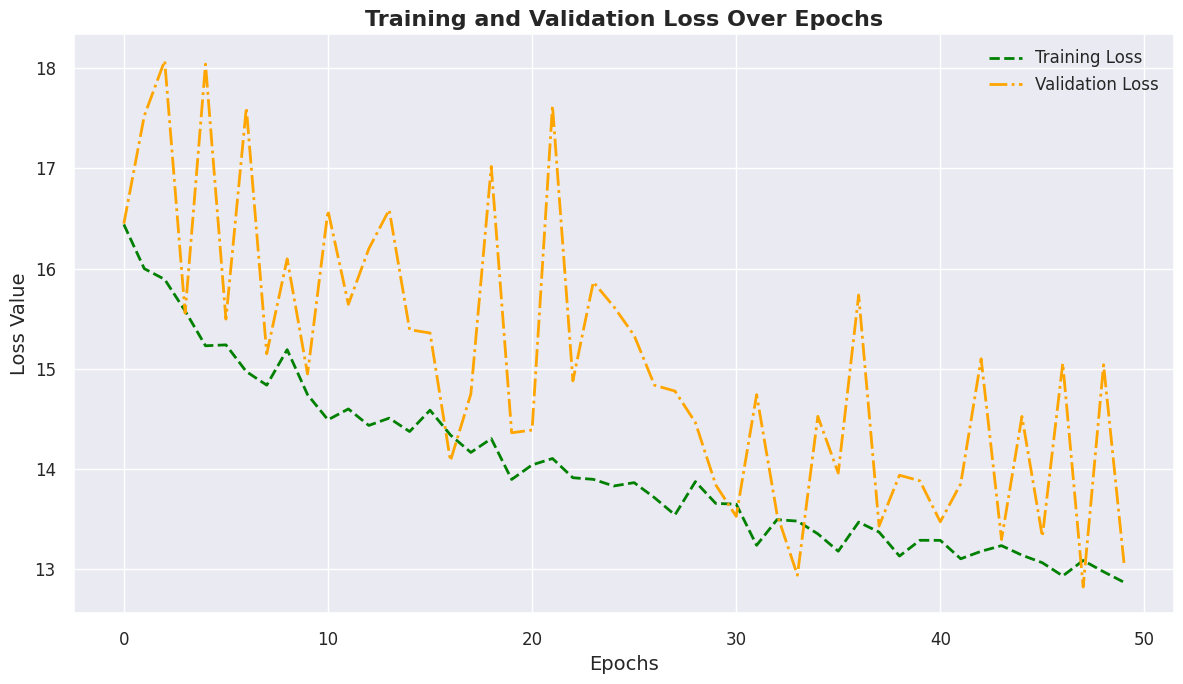

In [ ]:
# TODO: Plot training and validation loss over epochs
sns.set(style="darkgrid")
plt.figure(figsize=(12, 7))

plt.plot(train_losses, label="Training Loss", color="green", linestyle="--", linewidth=2)
plt.plot(val_losses, label="Validation Loss", color="orange", linestyle="-.", linewidth=2)

plt.title("Training and Validation Loss Over Epochs", fontsize=16, fontweight="bold")
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss Value", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12, loc="upper right")
plt.tight_layout()
plt.show()


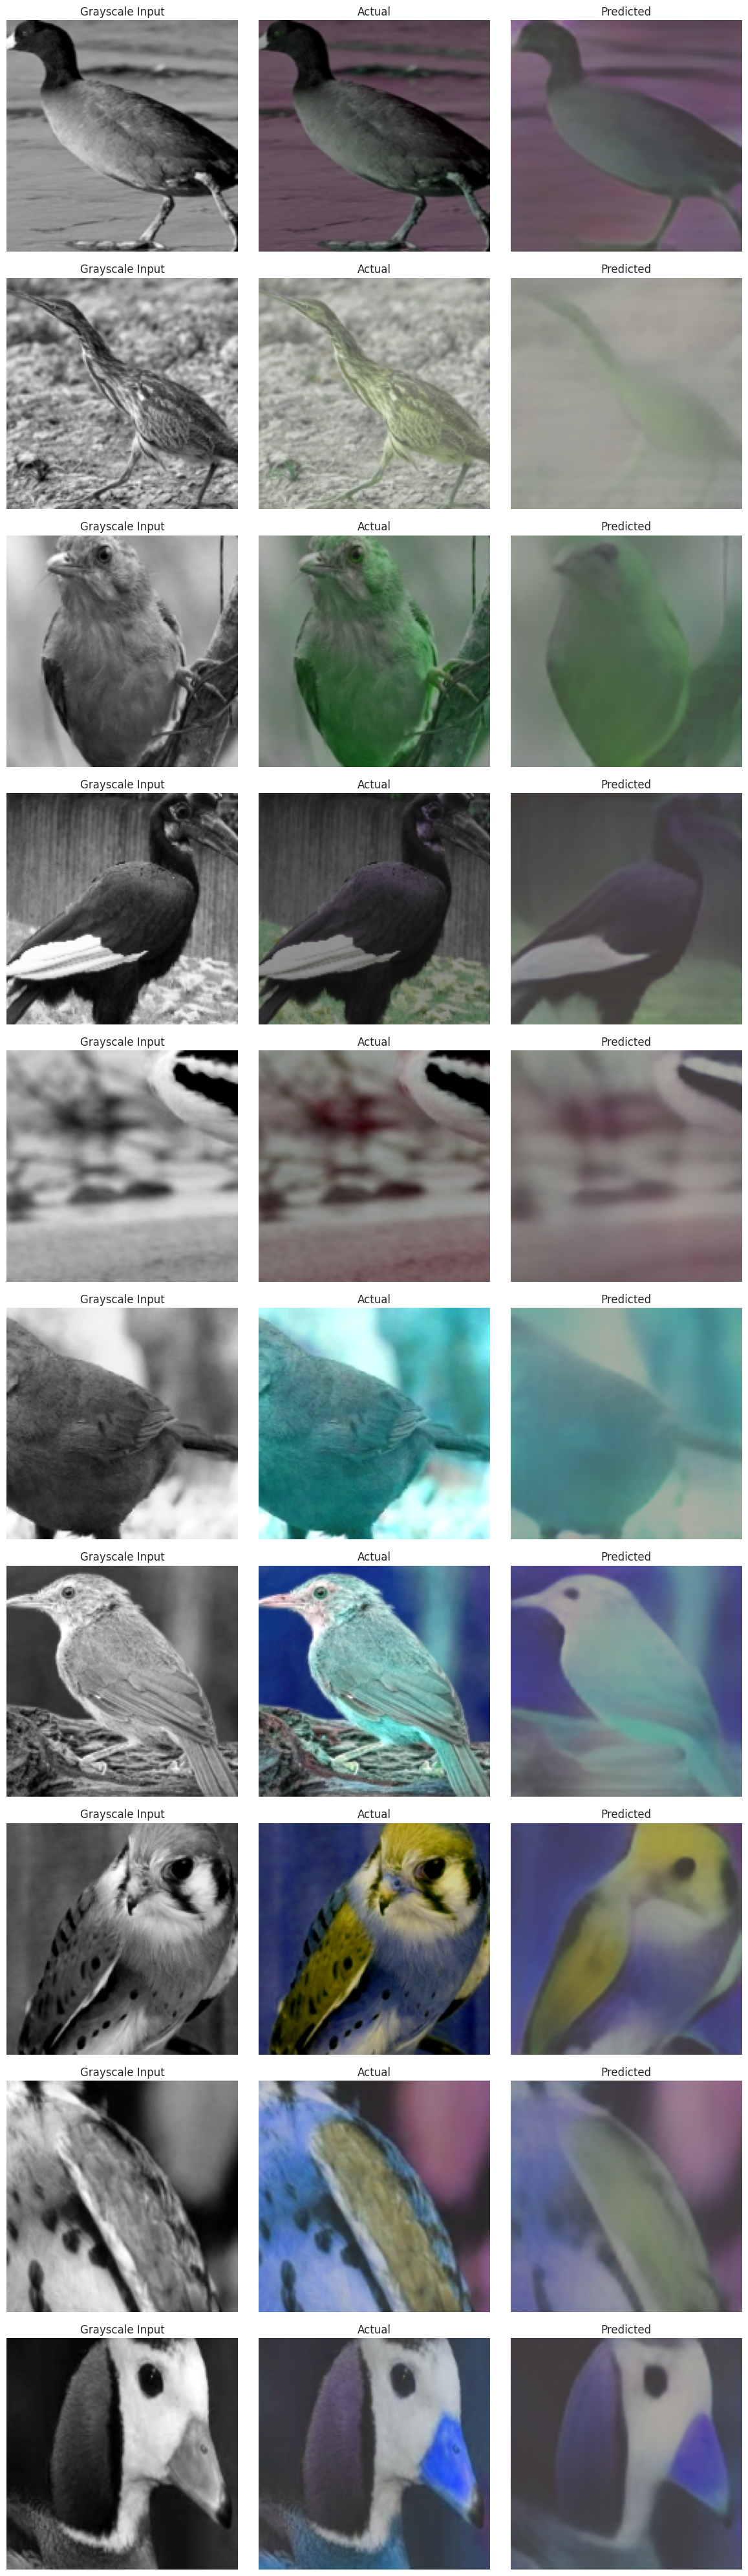

In [ ]:
# TODO: Plot grayscale, actual, and predicted inputs
def fetch_predictions(trained_model, data_loader, device):
    trained_model.eval()
    with torch.no_grad():
        for batch_images, _ in data_loader:
            batch_images = batch_images.to(device)
            predictions = trained_model(batch_images)
            return batch_images.cpu(), predictions.cpu()

# Retrieve actual and predicted images
real_images, generated_images = fetch_predictions(model, valid_loader, device)

# Revert normalization
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)

real_images = real_images * normalization_std + normalization_mean
generated_images = generated_images * normalization_std + normalization_mean

def convert_tensor_to_numpy(image_tensor):
    # Ensure the tensor is clamped between 0 and 1 for valid color range
    image_tensor = image_tensor.clamp(0, 1)
    # Convert from [C, H, W] to [H, W, C] for visualization
    return image_tensor.permute(0, 2, 3, 1).numpy()

real_images_np = convert_tensor_to_numpy(real_images)
generated_images_np = convert_tensor_to_numpy(generated_images)
grayscale_images_np = real_images_np.mean(axis=-1)  # Grayscale is the mean of color channels

# Plot a subset of images
images_to_display = 10
indices = np.random.choice(len(real_images_np), images_to_display, replace=False)

plt.figure(figsize=(12, images_to_display * 4))  # Adjust figure size to maintain image scale

for i, index in enumerate(indices):
    # Grayscale Input
    plt.subplot(images_to_display, 3, 3 * i + 1)
    plt.imshow(grayscale_images_np[index], cmap="gray")
    plt.title("Grayscale Input")
    plt.axis("off")

    # Real Image
    plt.subplot(images_to_display, 3, 3 * i + 2)
    plt.imshow(real_images_np[index])
    plt.title("Actual")
    plt.axis("off")

    # Generated Image
    plt.subplot(images_to_display, 3, 3 * i + 3)
    plt.imshow(generated_images_np[index])
    plt.title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Visualizing the Latent Space
# Latent space visualizations are a powerful tool to understand how the VAE encodes data.
# In this task, students are required to implement a visualization routine to observe the distribution of their data within the latent space.
# The goal is to project high-dimensional encoded data into two dimensions using t-SNE and inspect how different data points are clustered.

from matplotlib.colors import ListedColormap

def visualizing_latentspace(encoder_model, dataloader, sample_limit=1000):

    encoder_model.eval()  # Set encoder to evaluation mode

    device = next(encoder_model.parameters()).device  # Detect the model's device

    latent_space = []
    class_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # Transfer the batch to the correct device
            inputs = inputs.to(device)

            # Get the latent space representation from the encoder
            encoded_features = encoder_model(inputs)

            # Flatten spatial dimensions (e.g., using Global Average Pooling)
            encoded_features = encoded_features.mean(dim=(2, 3))

            latent_space.append(encoded_features.cpu())
            class_labels.append(targets)

            # Stop early if sample limit is reached
            if len(latent_space) * inputs.size(0) >= sample_limit:
                break

    # Combine all collected data into tensors
    latent_space = torch.cat(latent_space, dim=0)[:sample_limit]
    class_labels = torch.cat(class_labels, dim=0)[:sample_limit]

    # Use t-SNE for dimensionality reduction
    tsne_model = TSNE(n_components=2, perplexity=30, random_state=123, n_iter=1000)
    reduced_data = tsne_model.fit_transform(latent_space.numpy())

    # Generate a custom colormap for better visualization
    unique_labels = np.unique(class_labels.numpy())
    num_classes = len(unique_labels)
    colors = ListedColormap(plt.cm.get_cmap('tab20', num_classes).colors)

    # Plot the t-SNE results
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(
        reduced_data[:, 0], reduced_data[:, 1],
        c=class_labels.numpy(),
        cmap=colors,
        edgecolor='k',
        s=20,
        alpha=0.8
    )
    plt.colorbar(scatter, label="Class Labels")
    plt.title("Latent Space Visualization with t-SNE", fontsize=16, fontweight='bold')
    plt.xlabel("t-SNE Axis 1", fontsize=12)
    plt.ylabel("t-SNE Axis 2", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()


